# Vision Transformer for VALDO Dataset

This version is based on: https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

## Imports

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import nibabel as nib
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from transformers import ViTForMaskedImageModeling, ViTFeatureExtractor

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging

# Set the logging level for nibabel.global to WARNING to suppress INFO messages
logging.getLogger('nibabel.global').setLevel(logging.WARNING)

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some labels exceed the number of classes. Clamping labels.")


In [3]:
class VALDODataset(Dataset):
    def __init__(self, cases, masks, transform):
        self.cases = cases
        self.masks = masks
        self.transform = transform
        self.cmb_counts = self.count_cmb_per_image(self.masks)

        assert len(self.cases) == len(self.masks), 'Cases and masks must have the same length'
    
    def __len__(self):
        return len(self.cases)
    
    def __getitem__(self, idx):
        try:
            case = self.cases[idx]
            mask = self.masks[idx]

            slices = []
            masks = []

        
            s, m = self.transform(mri_image_path=case, segmentation_mask_path=mask)
            if s is None or m is None:
                raise ValueError(f"Transform returned None for {case} and {mask}")
            
            
            slices.append(s)
            masks.append(m)
            
            # print(f'Loaded image {case} and mask {mask}')
            return slices, masks, case, self.cmb_counts[idx]

        except Exception as e:
            print(f'Error loading image: {e}')
            return None, None, None, None
    
    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([(x-(w/2.5)), (y-(h/2.5)), ((w+x) + (w/3)), ((h+y) + (h/3))])
            # boxes.append([x, y, x +     w, y + h])
        return boxes

    def count_cmb_per_image(self, segmented_images):
        cmb_counts = []
        for img_path in segmented_images:
            img = nib.load(img_path)
            data = img.get_fdata()
            slice_cmb_counts = [self.extract_bounding_boxes(
                (data[:, :, i] > 0).astype(np.uint8)) for i in range(data.shape[2])]
            total_cmb_count = sum(len(contours)
                                  for contours in slice_cmb_counts)
            cmb_counts.append(total_cmb_count)
        return cmb_counts


## Transform

In [4]:
logging.getLogger('nibabel').setLevel(logging.WARNING)
def load_nifti(file_path):
    try:
        nifti = nib.load(file_path)
        data = nifti.get_fdata()
        # print(f"Loaded NIfTI data shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

class NiftiToTensorTransform:
    def __init__(self, target_shape=(256, 256), in_channels=1):
        self.target_shape = target_shape
        self.in_channels = in_channels
        self.transform = A.Compose([
            A.Resize(height=target_shape[0], width=target_shape[1], p=1.0, always_apply=True),
            ToTensorV2()
        ], is_check_shapes=False)  # Disable shape checking if you are sure about your data consistency

    def convert_to_binary_mask(self, segmentation_mask):
        binary_mask = (segmentation_mask > 0).astype(np.uint8)
        return binary_mask

    def __call__(self, mri_image_path, segmentation_mask_path):
        try:
            # Load the images
            mri_image = load_nifti(mri_image_path)
            segmentation_mask = load_nifti(segmentation_mask_path)
            dim_img = nib.load(mri_image_path).header['dim'][0]

            if mri_image is None or segmentation_mask is None:
                raise ValueError("Failed to load NIfTI files or data is None.")

            # Convert multi-label mask to binary mask
            binary_mask = self.convert_to_binary_mask(segmentation_mask)

            if mri_image.shape[0] != dim_img:
                # If the number of channels is not equal to dim, adjust it
                mri_image = np.repeat(mri_image, dim_img, axis=0)
            
            
            # Apply transformations to the entire volume
            augmented = self.transform(image=mri_image, mask=binary_mask)
            image = augmented['image']
            mask = augmented['mask']

            # # Ensure the number of channels matches the expected input channels
            # if image.shape[0] != self.in_channels:
            #     raise ValueError(f"Expected {self.in_channels} input channels, but got {image.shape[0]} channels. Channels should be {self.in_channels}. MRI Image is {mri_image.shape}")

            
            # Debugging prints
            # print(f"Image shape after transform: {image.shape}")
            # print(f"Mask shape after transform: {mask.shape}")
            # print(f"Unique values in the transformed mask: {torch.unique(mask)}")

            return image, mask
        except Exception as e:
            print(f"Error in __call__ with {mri_image_path} and {segmentation_mask_path}: {e}")
            return None, None


In [5]:
transform = NiftiToTensorTransform()

## Load the data

### Dataloader

In [6]:
testing_label_relative = '../VALDO_Dataset/Task2'
current_directory = os.getcwd()

two_directories_up = os.path.abspath(os.path.join(current_directory, "../"))

# Combine the current directory with the relative path
testing_label_absolute = os.path.join(
    two_directories_up, testing_label_relative)

folders = [item for item in os.listdir(testing_label_absolute) if os.path.isdir(
    os.path.join(testing_label_absolute, item))]

cases = {"cohort1": [], "cohort2": [], "cohort3": []}
# Print the list of folders
for folder in folders:
    if "sub-1" in folder:
        cases["cohort1"].append(folder)
    elif "sub-2" in folder:
        cases["cohort2"].append(folder)
    else:
        cases["cohort3"].append(folder)

In [7]:
cohort1_labels = []
cohort1_ids = []
for case in cases["cohort1"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort1_labels.append(label)
    cohort1_ids.append(id)
# print("Label:", cohort1_labels, cohort1_labels.__len__())
# print("Ids:", cohort1_ids, cohort1_ids.__len__())

cohort2_labels = []
cohort2_ids = []
for case in cases["cohort2"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort2_labels.append(label)
    cohort2_ids.append(id)
# print("Label:", cohort2_labels, cohort2_labels.__len__())
# print("Ids:", cohort2_ids, cohort2_ids.__len__())

cohort3_labels = []
cohort3_ids = []
for case in cases["cohort3"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort3_labels.append(label)
    cohort3_ids.append(id)
# print("Label:", cohort3_labels, cohort3_labels.__len__())
# print("Ids:", cohort3_ids, cohort3_ids.__len__())

all_labels = cohort1_labels + cohort2_labels + cohort3_labels
all_ids = cohort1_ids + cohort2_ids + cohort3_ids

# print(all_labels[0])
# print(all_ids[0])

In [8]:
print("Length of cohort1: ", len(cases["cohort1"])) 

Length of cohort1:  11


# Global Variables

In [9]:
d_model = 3
n_classes = 2
img_size = (256,256)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 1
epochs = 5
alpha = 0.005

### Collate 

In [10]:
def collate_fn(batch):
    slices = []
    targets = []
    img_paths = []
    cmb_counts = []

    for item in batch:
        if item is not None:  # Skip None items
            item_slices, item_targets, item_img_path, item_cmb_counts = item
            slices.extend(item_slices)
            targets.extend(item_targets)
            img_paths.append(item_img_path)
            cmb_counts.append(item_cmb_counts)

    if slices:
        cases = torch.stack(slices, dim=0)
        masks = torch.stack(targets, dim=0)
        return cases, masks, img_paths, cmb_counts
    else:
        return None, None, [], []

In [11]:
dataset = VALDODataset(
    cases=all_ids, masks=all_labels, transform=transform)

# dataset = VALDODataset(
#     cases=cohort1_ids, masks=cohort1_labels, transform=transform)

In [12]:
print(type(dataset))
print(len(dataset))

<class '__main__.VALDODataset'>
72


In [13]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

# df_dataset

In [14]:
train_df, val_df = train_test_split(
    df_dataset, test_size=0.2, stratify=df_dataset['Has CMB'], random_state=42)

In [15]:
print(val_df)

                                            MRI Scans  \
42  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
20  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
40  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
48  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
23  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
54  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
49  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
46  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
63  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
65  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
1   c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
15  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
30  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
39  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   
14  c:\Users\nigel\Documents\Thesis\Thesis_Tests\....   

                                      Segmented Masks  CMB Count  Has CMB  
42  c:\User

In [16]:
train_dataset = VALDODataset(train_df['MRI Scans'].tolist(
), train_df['Segmented Masks'].tolist(), transform=transform)
val_dataset = VALDODataset(val_df['MRI Scans'].tolist(
), val_df['Segmented Masks'].tolist(), transform=transform)

In [17]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_fn)

In [18]:
# for i, data in enumerate(train_loader, 0): 
#     print(i)
#     inpt = data[0][0][0][34]
#     mask = data[1][0][0][34]
#     print("Input", len(inpt))
#     print("Mask", len(mask))
#     print("Input", inpt)
#     print("Mask", mask)
#     break

In [19]:
# for i, data in enumerate(train_loader, 0): 
#     print(i)
#     inpt = data[0][0]
#     mask = data[1][0][0][4]
#     print("Input", len(inpt))
#     print("Mask", len(mask))
#     print("Input", inpt.shape)
#     print("Mask", mask.shape)
#     break

## CUDA

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
print(train_dataset[0])

([tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.

# Patch Embeddings

**B**: Batch Size <br>
**C** : Image channels  <br>
**H**: Image Height <br>
**W**: Image Width  <br>
**P_col**: Patch Columns  <br>
**P_row**: Patch Rows  <br>

In [22]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)
  def forward(self, x):
    # print("inpt is ", x.shape)
    x = x.unsqueeze(0)
    # print(x.shape)
    # Average across the 35-dimension
    x = torch.mean(x, dim=2)
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)

    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)

    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)
    
    return x

In [23]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()

    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, d_model)

    for pos in range(max_seq_length):
      for i in range(d_model):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Expand to have class token for every image in batch
    tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

    # Adding class tokens to the beginning of each embedding
    x = torch.cat((tokens_batch,x), dim=1)

    # Add positional encoding to embeddings
    x = x + self.pe

    return x

In [24]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

In [25]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    # Combine attention heads
    out = torch.cat([head(x) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

In [26]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [27]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [28]:
class SegmentationHead(nn.Module):
    def __init__(self, embed_dim, num_classes, image_size, patch_size):
        super(SegmentationHead, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size[0]) * (image_size // patch_size[1])  # Corrected num_patches calculation

        # Calculate side length of the patches
        side_length = int(self.num_patches ** 0.5)
        if side_length ** 2 != self.num_patches:
            raise ValueError("Number of patches is not a perfect square")

        # Define the Conv2d layer
        self.conv = nn.Conv2d(embed_dim, num_classes, kernel_size=1, padding=0)
    
    def forward(self, x):
        # Check and move 'self.conv' weights to the same device as 'x'
        if x.device != self.conv.weight.device:
            self.conv = self.conv.to(x.device)
        
        batch_size, num_patches, embed_dim = x.shape
        expected_patches = self.num_patches  # No additional token in this context
        
        if num_patches > expected_patches:
            x = x[:, :expected_patches, :]
        elif num_patches < expected_patches:
            padding = torch.zeros(batch_size, expected_patches - num_patches, embed_dim).to(x.device)
            x = torch.cat((x, padding), dim=1)

        x = x.to(x.device)
        x = x.transpose(1, 2)  # Swap dimensions to [batch_size, embed_dim, num_patches]

        side_length = int(self.num_patches ** 0.5)
        x = x.view(batch_size, embed_dim, side_length, side_length)  # Reshape to [batch_size, embed_dim, sqrt(num_patches), sqrt(num_patches)]
        
        x = self.conv(x)  # Apply convolution
        return x


In [29]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])
    self.segmentation_head = SegmentationHead(self.d_model, self.n_classes, self.img_size[0], self.patch_size)


  def forward(self, images):
    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)
    
    x = self.segmentation_head(x)

    return x

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [31]:
torch.backends.cudnn.benchmark = False


In [32]:
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)


In [33]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
  training_loss = 0.0
  for i, data in tqdm(enumerate(train_loader, 0), desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}'):
    # print("Data: ", data)
    inputs = data[0].float()
    mask = data[1].float()
    inputs, labels = inputs.to(device), mask.to(device)
    # labels = labels.squeeze(-1)
    labels = torch.argmax(labels, dim=-1)
    optimizer.zero_grad()
    outputs = transformer(inputs)
    outputs = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
    # print("Outputs: ", outputs)
    # print("Labels: ", labels)
    if labels.max() >= n_classes:
      # print("Warning: Some labels exceed the number of classes. Clamping labels.")
      labels = torch.clamp(labels, 0, n_classes - 1)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()

  print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')

Epoch 1/5 loss: 0.000: 0it [00:00, ?it/s]

Epoch 1/5 loss: 1.923


Epoch 2/5 loss: 0.000: 0it [00:00, ?it/s]

Epoch 2/5 loss: 1.110


Epoch 3/5 loss: 0.000: 0it [00:00, ?it/s]

Epoch 3/5 loss: 6.818


Epoch 4/5 loss: 0.000: 0it [00:00, ?it/s]

Epoch 4/5 loss: 9.421


Epoch 5/5 loss: 0.000: 0it [00:00, ?it/s]

Epoch 5/5 loss: 7.731


In [34]:
import os

dir_path = 'experiments'
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
tensor([[[0, 0, 0,  ..., 0, 

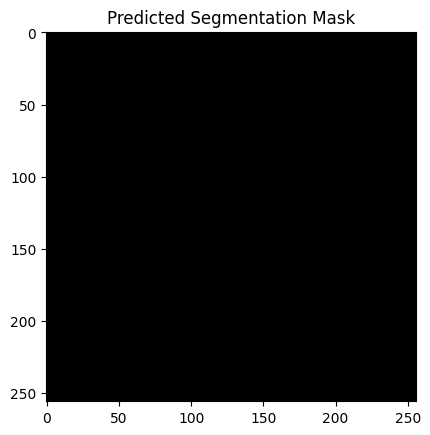

In [52]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the trained model weights
model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers)
model.to(device)
model.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
model.eval()

def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
    return prediction.cpu().numpy()

# Make a prediction
val_loss = 0.0
predicted = []

with torch.no_grad():
    for val_batch in test_loader:
        val_images, val_masks, _, _ = val_batch
        val_images = val_images.float().to(device)

        predicted_mask = predict(model, val_images)

        val_masks = torch.argmax(val_masks, dim=1).to(device)  # Keep as long for now

        # Ensure val_masks and predicted_mask have the same dimensions
        val_masks = F.interpolate(val_masks.unsqueeze(1).float(), size=img_size, mode='nearest').squeeze(1).long()

        # Resize predicted_mask to match val_masks size
        predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()  # Convert to float for loss calculation
        predicted_mask = F.interpolate(predicted_mask, size=img_size, mode='nearest').squeeze(1).long()

        val_loss += criterion(predicted_mask.float(), val_masks.float()).item()  # Convert both to float for loss calculation
        predicted.append(predicted_mask)
        print("predicted_mask", predicted_mask)
        print("val_masks", val_masks)

print(f'Validation Loss: {val_loss / len(test_loader)}')




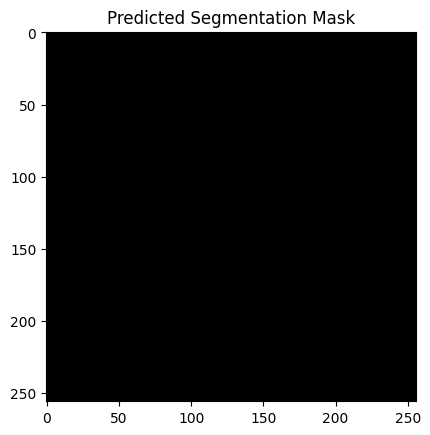

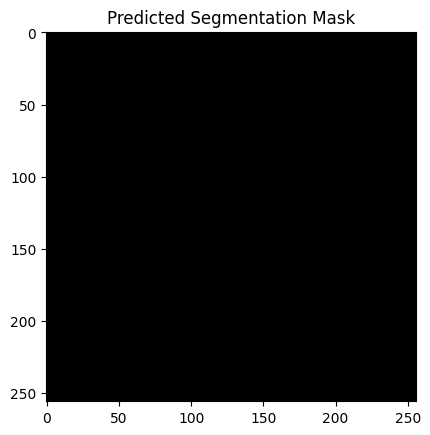

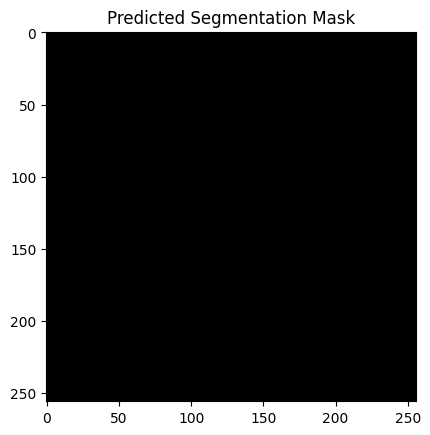

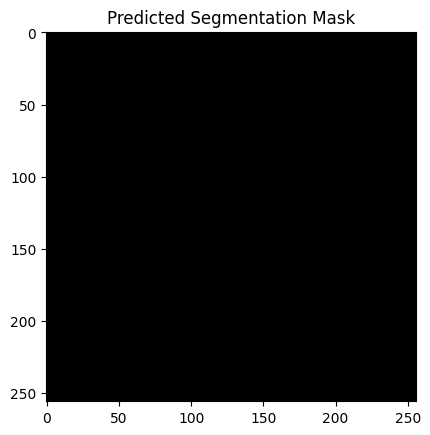

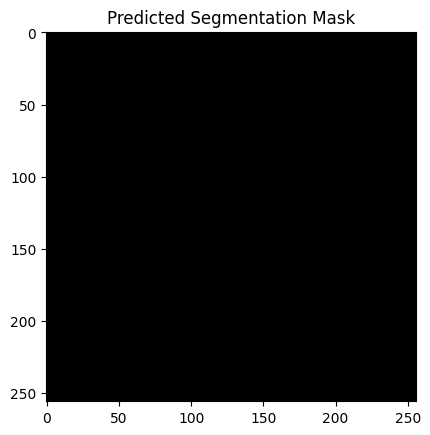

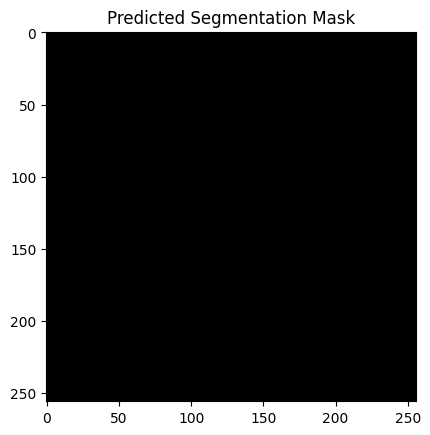

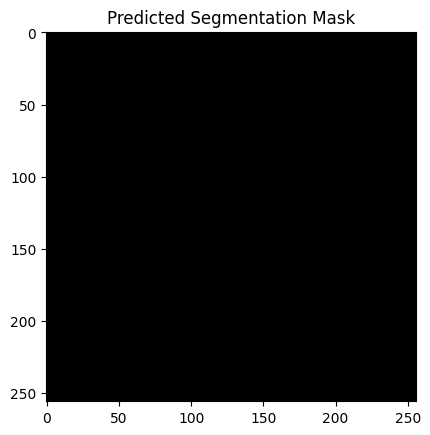

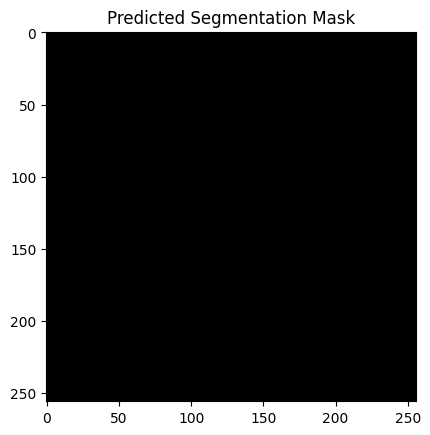

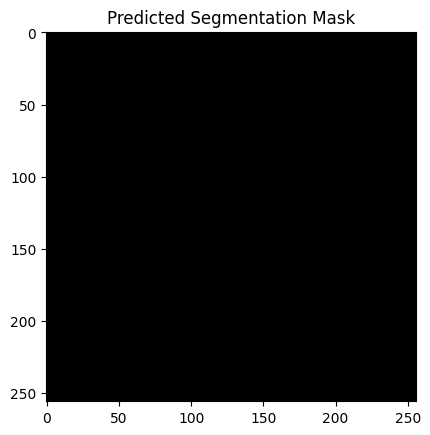

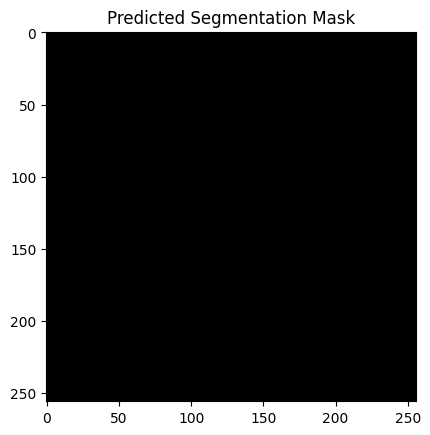

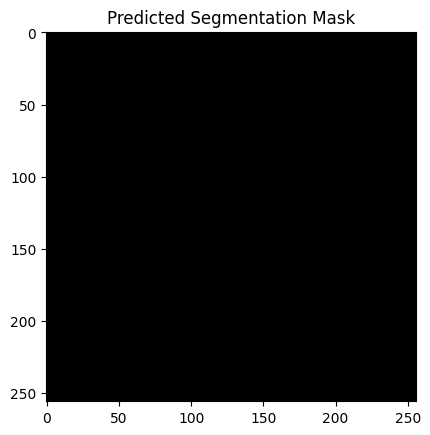

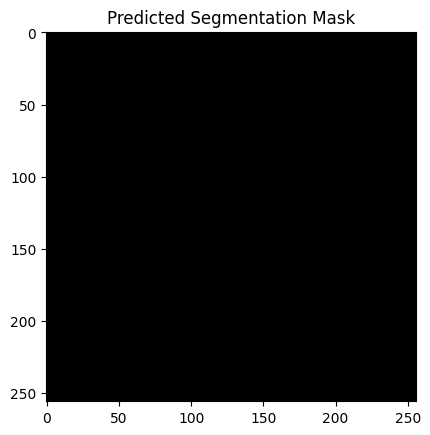

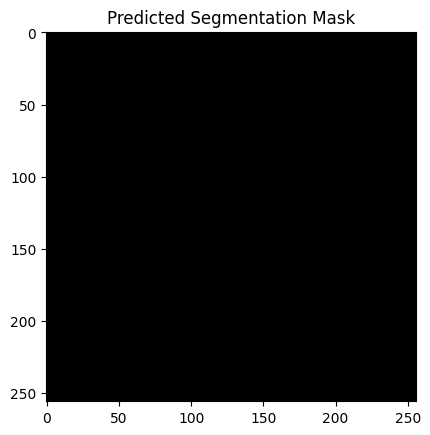

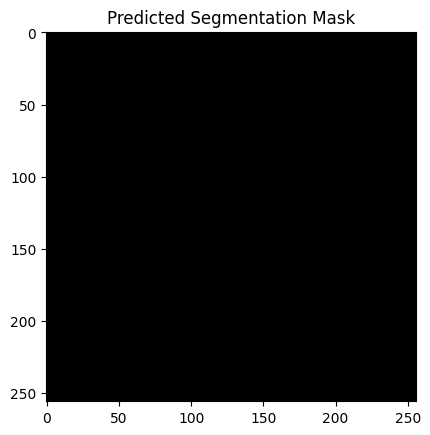

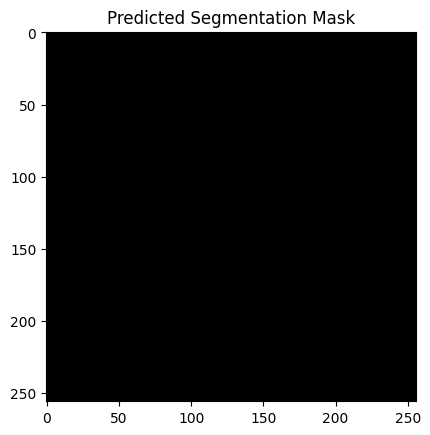

In [60]:
for i in range(len(predicted)):
    plt.imshow(predicted[i][0].cpu(), cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.show()